# Algorithm to compute the Emittance from 3 SEM GRIDS in the PSB

This analysis is done based on a clone of the **LHC25ns-type beam (MD74_LHC25_SEMGRIDS) as produced in operation during 2016**.

For a given PSB ring/plane (to be set below) in this notebook the **transverse emittance** is computed starting from the **transverse profiles acquired at the 3 SEM GRIDS in the BTM line**.

Since there is no magnetic element between the grids it is possible to simply use the formulas for a DRIFT to construct the 3x3 transport matrix. More details are avaiable at slide 21 of https://cas.web.cern.ch/cas/France-2008/Lectures/Braun-Emittance.pdf. We kept the same notation to ease the reading.

The DataFrame will be stored in a pickle file (is the flag *saveData is set to True*) to retrieve the information and perform a global comparison between rings/planes and with the wirescanners in the PSB ring.

In [1]:
# Guido's GURU toolbox
import sys
sys.path.append('/eos/user/s/sterbini/MD_ANALYSIS/public/')
#you can add it in a the a configuration script to run at the start of SWAN e.g.:
# export PYTHONPATH="$PYTHONPATH:/eos/user/sb/sterbini/MD_ANALYSIS/public"
from myToolbox import *

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-327.36.3.el7.x86_64-x86_64-with-redhat-6.7-Carbon
Your folder is /eos/user/d/digiovan/MD_ANALYSIS/2016/MD74
Your IP is 172.17.0.7
2017-02-21 18:00:43


In [2]:
# GP's toolbox
sys.path.append('/eos/user/d/digiovan/MD_ANALYSIS/public/')
from gpToolbox import *

Version 0.01.
Use it at your risk. In case please report any bug to digiovan@cern.ch.


In [3]:
# M A I N    S E T T I N G

# protons at PSB extraction
beta_rel  = 0.9160; 
gamma_rel = 2.4925;
Ekin      = 1.4000; # GeV
Energy    = 2.3380; # GeV
p         = 2.1410; # GeV

# The distance between the grids is 2.500 according to layout
# They have been corrected for the survey measurements. Minimal impact anyway
La = 0.000;      # m
Lb = La + 2.485; # m
Lc = Lb + 2.487; # m

# which ring/plane to test?
ring  = '1'
plane = 'H'

saveData = True

folder_data = 'PSB_r' + ring + '_p' + plane
folder_tomo = 'PSB_r' + ring + '_tomograms_' + plane

# Uncomment for quick check
#print folder_data
#print folder_tomo

In [4]:
# Get the list of files from the WS
#matfiles=sorted(glob.glob('/eos/user/d/digiovan/MD_ANALYSIS/2016/MD74/data/sem/' + folder_data +'/*mat'))
matfiles=sorted(glob.glob('/eos/user/d/digiovan/MD_ANALYSIS/2016/MD74/data/ws_sem/' + folder_data +'/*mat'))
print "loaded", len(matfiles), "matfiles"
#print matfiles[0]
#print matfiles

# Simple test for checking the variables stored
#myExample=myToolbox.japcMatlabImport(matfiles[0])

# write "myExample." and then press "Tab" to check which variable is stored
#myExample.

# emittance from JF's application
#myExample.BTM_BSFHV01.Emittance.value.emittance

loaded 40 matfiles


In [5]:
# Convert to dataFrame
myDataFrame=myToolbox.fromMatlabToDataFrame(matfiles,['BR_BCTDC.Acquisition.value.extIntensityRing'+ring,
                                                      'BTM_BSFHV01.Acquisition.value.projPositionSet1',
                                                      'BTM_BSFHV01.Acquisition.value.projDataSet1',
                                                      'BTM_BSFHV02.Acquisition.value.projPositionSet1',
                                                      'BTM_BSFHV02.Acquisition.value.projDataSet1',
                                                      'BTM_BSFHV03.Acquisition.value.projPositionSet1',
                                                      'BTM_BSFHV03.Acquisition.value.projDataSet1',
                                                      'BTM_BSFHV01.Emittance.value.emittance']);

# Uncomment to check if the data are properly loaded
#myDataFrame['BR'+ring+'_B2L1_'+plane+'H_ROT.Logging.value.projPositionSet1']
#myDataFrame['BR_BCTDC.Acquisition.value.extIntensityRing'+ring]

In [6]:
# Add a list of tomofiles
tomoFilePath = []

#tomofiles = sorted(glob.glob('data/sem/'+ folder_tomo + '/*dat'))
tomofiles = sorted(glob.glob('data/ws_sem/'+ folder_tomo + '/*dat'))

if len(tomofiles) != len(matfiles):
    print "Mismatch: the lenghts of files and tomograms is NOT the same"
else:
    print "1-to-1 Matching with tomofiles"
    for i in tomofiles:
        # uncomment in case you want to have a look at the files
        #print(i)
        tomoFilePath.append(i)
    
    # add the tomograms to the DataFrame... assuming 1-to-1 correspondence (no matching with timestamp...)
    myDataFrame['tomoFilePath'] = pnd.Series(tomoFilePath, index=myDataFrame.index)
    
#myDataFrame['tomoFilePath'].values

1-to-1 Matching with tomofiles


In [7]:
# directly copied from one of Guido's analyses
def extractProfile(fileName):
    '''Give me the input file (.dat) of the tomogram and I will give you 2 output:
        the deltaP_P and the the momentum distribution profile.
    ''' 

    print '/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName
    a=os.system('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    
    convergence=np.loadtxt('./' + fileName[0:-4] + '/d001.data')
    image=np.loadtxt('./' + fileName[0:-4] + '/image001.data')
    with open('./' + fileName[0:-4] + '/input_v2.dat','r') as stream: tomofileheader = stream.readlines()[:98]

    myInput={'PLSUSER': tomofileheader[0][0:-1],
            'NumberOfframes': np.int(tomofileheader[16][0:-1]),
            'B_T': np.double(tomofileheader[75][0:-1]),
            'Bdot_T_per_s': np.double(tomofileheader[77][0:-1]),
            'machineRadius_m': np.double(tomofileheader[79][0:-1]),
            'bendingRadius_m': np.double(tomofileheader[81][0:-1]),
            'particleMass_eV': np.double(tomofileheader[85][0:-1]),
            'h': np.int(np.double(tomofileheader[69][0:-1])),
            'ctime': np.int(tomofileheader[2])
    }

    with open('./' + fileName[0:-4] + '/plotinfo.data','r') as stream: tomofileheader = stream.readlines()

    myInput['profilecount']=np.int(str.split(tomofileheader[1])[2])
    myInput['profilelength']=np.int(str.split(tomofileheader[3])[2])

    myInput['dtbin']=np.double(str.split(tomofileheader[5])[2])
    myInput['dEbin']=np.double(str.split(tomofileheader[7])[2])
    myInput['xat0']=np.double(str.split(tomofileheader[11])[2])
    myInput['yat0']=np.double(str.split(tomofileheader[12])[2])
    myInput['eperimage']=np.double(str.split(tomofileheader[9])[2])

    mySpeedOfLight=299792458. #TODO
    myInput['momentum_eV']=myInput['B_T']*myInput['bendingRadius_m']/(10/mySpeedOfLight*1e8)*1.e9 #TODO
    myInput['totalEnergy_eV']=np.sqrt(myInput['momentum_eV']**2+myInput['particleMass_eV']**2)
    myInput['gamma']=myInput['totalEnergy_eV']/myInput['particleMass_eV']
    myInput['beta']=np.sqrt(1-1/myInput['gamma']**2)

    image=image*myInput['eperimage']/myInput['dtbin']/myInput['dEbin']

    halfProfileLength=myInput['profilelength']/2.

    Toffset= (myInput['xat0']-halfProfileLength)*myInput['dtbin']*1e9
    Eoffset= (myInput['yat0']-halfProfileLength)*myInput['dEbin']/1e6

    t=np.arange(-halfProfileLength,halfProfileLength)*myInput['dtbin']*1e9-Toffset
    E=np.arange(-halfProfileLength,halfProfileLength)*myInput['dEbin']/1e6-Eoffset


    deltaP_P= 1/myInput['beta']**2*E*1e6/myInput['totalEnergy_eV']
    myProfile=np.sum(np.reshape(image, [myInput['profilelength'], myInput['profilelength']]),0)
    myProfile=myProfile/np.trapz(myProfile,deltaP_P)
    myInput['deltaP_P']=deltaP_P;
    myInput['myProfile']=myProfile;
    myInput['E_MeV']=E
    myInput['t_ns']=t
    myInput['phaseSpace_e_per_eVs']=np.reshape(image, [myInput['profilelength'], myInput['profilelength']]);
    myProfileNormalized=myProfile/np.trapz(myProfile,deltaP_P)
    myMean=np.trapz(deltaP_P*myProfileNormalized,deltaP_P)
    myRMS=np.sqrt(np.trapz((deltaP_P-myMean)**2*myProfileNormalized,deltaP_P))
    myInput['deltaP_P_RMS']=myRMS
    return myInput

In [8]:
# calculate the Dp/p profile and add it to the DataFrame
myDataFrame['momentumProfile']=myDataFrame['tomoFilePath'].apply(extractProfile)

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r1_tomograms_H/R1ejref_New_2016_001.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r1_tomograms_H/R1ejref_New_2016_002.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r1_tomograms_H/R1ejref_New_2016_003.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r1_tomograms_H/R1ejref_New_2016_004.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r1_tomograms_H/R1ejref_New_2016_005.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r1_tomograms_H/R1ejref_New_2016_006.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r1_tomograms_H/R1ejref_New_2016_007.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r1_tomograms_H/R1ejref_New_2016_008.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo dat

In [9]:
isVerbose=False
# simpleMethod is the standard method assuming a Gaussian fit of the profiles and by removing the dispersion
# in a Gaussian fashion

def simpleMethod(myDataFrame):
          
    a1,b1=gpToolbox.makeGaussianFit(myDataFrame['BTM_BSFHV01.Acquisition.value.projPositionSet1'],
                                    myDataFrame['BTM_BSFHV01.Acquisition.value.projDataSet1'])
    
    a2,b2=gpToolbox.makeGaussianFit(myDataFrame['BTM_BSFHV02.Acquisition.value.projPositionSet1'],
                                    myDataFrame['BTM_BSFHV02.Acquisition.value.projDataSet1'])  

    a3,b3=gpToolbox.makeGaussianFit(myDataFrame['BTM_BSFHV03.Acquisition.value.projPositionSet1'],
                                    myDataFrame['BTM_BSFHV03.Acquisition.value.projDataSet1'])

    # measured beam sizes at the grids, including dispersion
    s_1 = a1[2]   
    s_2 = a2[2]
    s_3 = a3[2]

    Dp_p = myDataFrame['momentumProfile']['deltaP_P_RMS']

    D_1 = dispersion_measured['r'+ring][plane]['SG1']
    D_2 = dispersion_measured['r'+ring][plane]['SG2']
    D_3 = dispersion_measured['r'+ring][plane]['SG3']

    # only betatronic contribution, i.e. removing dispersion contribution
    # keep in mind that the dispersion is given in m while the sigma is in mm... convertion factor!
    sigma_bet_1 = math.sqrt( s_1**2 - (D_1*1000*Dp_p)**2 )
    sigma_bet_2 = math.sqrt( s_2**2 - (D_2*1000*Dp_p)**2 )
    sigma_bet_3 = math.sqrt( s_3**2 - (D_3*1000*Dp_p)**2 )

    # the input vector
    x = [sigma_bet_1**2, sigma_bet_2**2, sigma_bet_3**2]

    
    ##
    # construct the transport matrix when only drift between grids!
    # See slide 21 of https://cas.web.cern.ch/cas/France-2008/Lectures/Braun-Emittance.pdf
    Row_1 = [1, -2*La, La**2];
    Row_2 = [1, -2*Lb, Lb**2];
    Row_3 = [1, -2*Lc, Lc**2];

    # Create the matrix M
    M = np.matrix( [Row_1,Row_2,Row_3]) 
    if isVerbose:
        print M

    # left for reference
    # inverse of M
    # print M.I
    #print linalg.solve(A, x)     # Solve the linear equation system.
    
    ## output vector
    out = np.linalg.solve(M, x)

    # twiss parameters
    beta_x_emitRMS  = out[0]
    alpha_x_emitRMS = out[1]
    gamma_x_emitRMS = out[2]

    # RMS Emittance
    emitRMS = math.sqrt( beta_x_emitRMS*gamma_x_emitRMS - alpha_x_emitRMS**2)

    # Normalized Emittance
    emittance = emitRMS * beta_rel * gamma_rel

    # twiss parameter
    betaTwiss  = beta_x_emitRMS / emitRMS
    alphaTwiss = alpha_x_emitRMS/ emitRMS

    #============================================================================
    if not isVerbose:
       return emittance#,betaTwiss,alphaTwiss

    print '\nbet. sigma at 1st SEM = ', sigma_bet_1, ' mm'
    print   'bet. sigma at 2nd SEM = ', sigma_bet_2, ' mm'
    print   'bet. sigma at 3rd SEM = ', sigma_bet_3, ' mm'

    # print the output of the test
    print "RMS emittance = ", emitRMS, " mm mrad"
    print "Normalized emittance = ", emittance, "mm mrad"
    print "beta (twiss) = ", betaTwiss, "m"
    print "alpha (twiss) = ", alphaTwiss

    fig = plt.figure(figsize=(20,20))
    ax1 = fig.add_subplot(311)
    ax1.plot(myDataFrame['BTM_BSFHV01.Acquisition.value.projPositionSet1'],
             myDataFrame['BTM_BSFHV01.Acquisition.value.projDataSet1'])
    ax1.hold('on') 
    ax1.plot(myDataFrame['BTM_BSFHV01.Acquisition.value.projPositionSet1'], 
             gpToolbox.Gaussian(myDataFrame['BTM_BSFHV01.Acquisition.value.projPositionSet1'], *a1), 
             'r-', label='fit')
    ax1.hold('off')

    ax2 = fig.add_subplot(312)
    ax2.plot(myDataFrame['BTM_BSFHV02.Acquisition.value.projPositionSet1'],
             myDataFrame['BTM_BSFHV02.Acquisition.value.projDataSet1'])

    ax2.hold('on') 
    ax2.plot(myDataFrame['BTM_BSFHV02.Acquisition.value.projPositionSet1'], 
             gpToolbox.Gaussian(myDataFrame['BTM_BSFHV02.Acquisition.value.projPositionSet1'], *a2), 
             'r-', label='fit')
    ax2.hold('off')

    ax3 = fig.add_subplot(313)
    ax3.plot(myDataFrame['BTM_BSFHV03.Acquisition.value.projPositionSet1'],
             myDataFrame['BTM_BSFHV03.Acquisition.value.projDataSet1'])

    ax3.hold('on')
    ax3.plot(myDataFrame['BTM_BSFHV03.Acquisition.value.projPositionSet1'], 
             gpToolbox.Gaussian(myDataFrame['BTM_BSFHV03.Acquisition.value.projPositionSet1'], *a3), 
             'r-', label='fit')
    ax3.hold('off')
    
    return emittance#,betaTwiss,alphaTwiss

# Add the emittance calculated with simpleMethod in the dataframe    
myDataFrame['emittanceSG'] = myDataFrame.apply( simpleMethod , axis=1)

In [10]:
# store the sigma from the Gaussian Fit
def GaussianFit1stSG(myDataFrame):
          
    a1,b1=gpToolbox.makeGaussianFit(myDataFrame['BTM_BSFHV01.Acquisition.value.projPositionSet1'],
                                    myDataFrame['BTM_BSFHV01.Acquisition.value.projDataSet1'])
    
    # measured beam sizes at the grids, including dispersion
    s_1 = a1[2]   
    
    return s_1

def GaussianFit2ndSG(myDataFrame):
          
    a2,b2=gpToolbox.makeGaussianFit(myDataFrame['BTM_BSFHV02.Acquisition.value.projPositionSet1'],
                                    myDataFrame['BTM_BSFHV02.Acquisition.value.projDataSet1'])
    
    # measured beam sizes at the grids, including dispersion
    s_2 = a2[2]   
    
    return s_2

def GaussianFit3rdSG(myDataFrame):
          
    a3,b3=gpToolbox.makeGaussianFit(myDataFrame['BTM_BSFHV03.Acquisition.value.projPositionSet1'],
                                    myDataFrame['BTM_BSFHV03.Acquisition.value.projDataSet1'])
    
    # measured beam sizes at the grids, including dispersion
    s_3 = a3[2]   
    
    return s_3


# Add the sigma calculated with a standard Gaussian Fit in the DataFrame for each SEM GRID    
myDataFrame['sigma_gauss_s1'] = myDataFrame.apply( GaussianFit1stSG , axis=1)
myDataFrame['sigma_gauss_s2'] = myDataFrame.apply( GaussianFit2ndSG , axis=1)
myDataFrame['sigma_gauss_s3'] = myDataFrame.apply( GaussianFit3rdSG , axis=1)


Avg Sigma SG1 =  2.55301379572 +/- 0.0171550311376 mm
Avg Sigma SG2 =  1.43568730878 +/- 0.017429157444 mm
Avg Sigma SG3 =  2.77584887419 +/- 0.0216607947155 mm


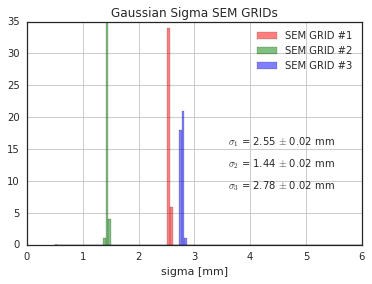

In [11]:
sns.set_style('white')

#Distribution of the sigma 
bins = np.linspace(0.5, 6.0, 110)

sigma_gauss_s1 = myDataFrame['sigma_gauss_s1'].values
sigma_gauss_s2 = myDataFrame['sigma_gauss_s2'].values
sigma_gauss_s3 = myDataFrame['sigma_gauss_s3'].values

f = plt.figure()

plt.hist( sigma_gauss_s1, bins, facecolor='red',   alpha=0.5, label='SEM GRID #1') 
plt.hold('on')
plt.hist( sigma_gauss_s2, bins, facecolor='green', alpha=0.5, label='SEM GRID #2') 
plt.hist( sigma_gauss_s3, bins, facecolor='blue',  alpha=0.5, label='SEM GRID #3') 

plt.xlabel('sigma [mm]')
plt.title('Gaussian Sigma SEM GRIDs')
plt.legend()
plt.grid(True)

#plt.text(5.0, 0.9,'matplotlib',ha='center', va='center')
s1_avg = np.mean(sigma_gauss_s1)
s1_std = np.std (sigma_gauss_s1)

s2_avg = np.mean(sigma_gauss_s2)
s2_std = np.std (sigma_gauss_s2)

s3_avg = np.mean(sigma_gauss_s3)
s3_std = np.std (sigma_gauss_s3)

plt.annotate('$\sigma_1$ = {0:0.2f} $\pm$ {1:0.2f} mm'.format(s1_avg, s1_std), 
            (0.60, 0.45), textcoords='axes fraction', xycoords='axes fraction', size=10)
plt.annotate('$\sigma_2$ = {0:0.2f} $\pm$ {1:0.2f} mm'.format(s2_avg, s2_std), 
            (0.60, 0.35), textcoords='axes fraction', xycoords='axes fraction', size=10)
plt.annotate('$\sigma_3$ = {0:0.2f} $\pm$ {1:0.2f} mm'.format(s3_avg, s3_std), 
            (0.60, 0.25), textcoords='axes fraction', xycoords='axes fraction', size=10)

plt.hold('off')

f.savefig('plots/sigmaGaussian_semgrid_r'+ring+'_p'+plane+'.pdf')
f.savefig('plots/sigmaGaussian_semgrid_r'+ring+'_p'+plane+'.png')

print "Avg Sigma SG1 = ",   np.mean(sigma_gauss_s1),   "+/-", np.std(sigma_gauss_s1) ,  "mm"
print "Avg Sigma SG2 = ",   np.mean(sigma_gauss_s2),   "+/-", np.std(sigma_gauss_s2) ,  "mm"
print "Avg Sigma SG3 = ",   np.mean(sigma_gauss_s3),   "+/-", np.std(sigma_gauss_s3) ,  "mm"



[[  1.        -0.         0.      ]
 [  1.        -4.97       6.175225]
 [  1.        -9.944     24.720784]]

bet. sigma at 1st SEM =  1.98393474665  mm
bet. sigma at 2nd SEM =  1.42562239787  mm
bet. sigma at 3rd SEM =  2.34861191126  mm
RMS emittance =  0.927681675544  mm mrad
Normalized emittance =  2.11801786389 mm mrad
beta (twiss) =  4.24283154743 m
alpha (twiss) =  0.996556732877

 *** emittance from JFC's application =  2.17945590118  mm mrad


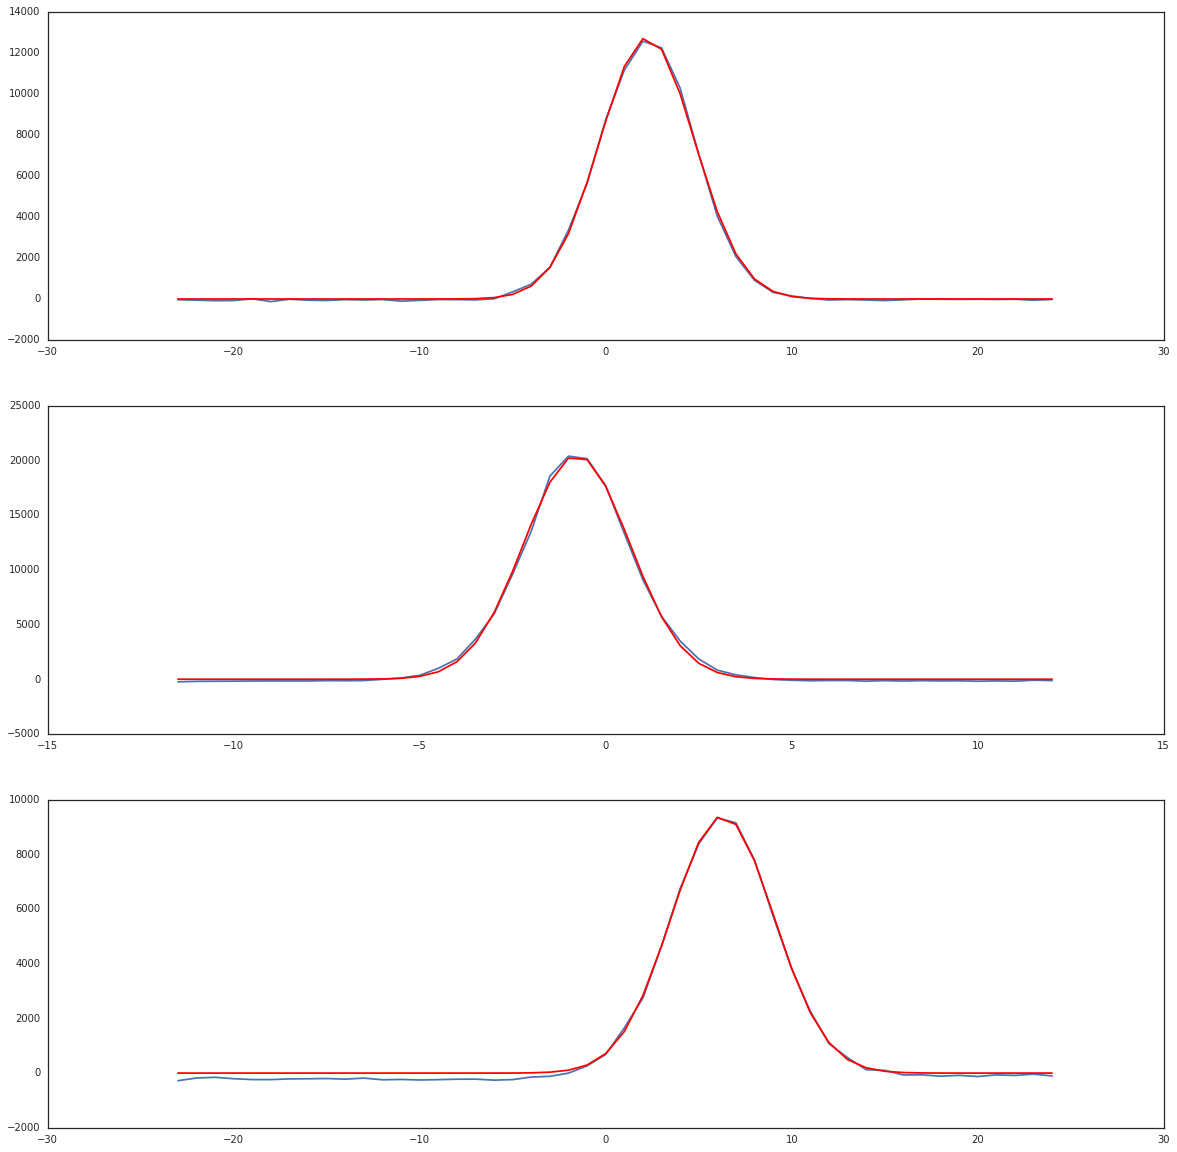

In [12]:
# this is a test to plot some fit and compare the output with the default application from Jean-Francois Comblin
sns.set_style('white')

# test 
i = 2
isVerbose = True
out = simpleMethod (myDataFrame.iloc[i])

print "\n *** emittance from JFC's application = ", myDataFrame.iloc[i]['BTM_BSFHV01.Emittance.value.emittance'], " mm mrad"

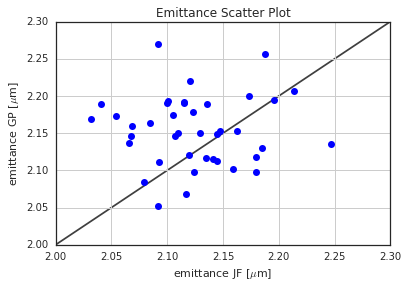

In [13]:
# plot of emittance from my method vs JFC's. Ideally they should yield compatible results
sns.set_style('white')

f = plt.figure()

plt.plot(myDataFrame['BTM_BSFHV01.Emittance.value.emittance'],myDataFrame['emittanceSG'],'bo')
plt.xlabel('emittance JF [$\mu$m]')
plt.ylabel('emittance GP [$\mu$m]')
plt.grid(True)
plt.title('Emittance Scatter Plot')

plt.hold('on')
lims = [
    np.min([plt.xlim(), plt.ylim()]),  # min of both axes
    np.max([plt.xlim(), plt.ylim()]),  # max of both axes
]

# now plot both limits against eachother
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlim(lims)
plt.ylim(lims)
plt.hold('off')

f.savefig('plots/scatterEmittanceGPvsJF_semgrid_r'+ring+'_p'+plane+'.pdf')
f.savefig('plots/scatterEmittanceGPvsJF_semgrid_r'+ring+'_p'+plane+'.png')


Avg Emittance GP =  2.15399432454 +/- 0.0465481335663 mm mrad
Avg Emittance JF =  2.12467145442 +/- 0.0469460266351 mm mrad
Avg Emittance Diff =  0.0293228701155 +/- 0.0657492295177 mm mrad


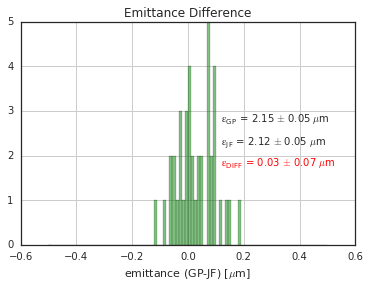

In [14]:
#Another way to look at the same comparison in the cell above
bins = np.linspace(-0.5, 0.5, 91)

gpEmittance   = myDataFrame['emittanceSG'].values
jfEmittance   = myDataFrame['BTM_BSFHV01.Emittance.value.emittance'].values
diffEmittance = gpEmittance-jfEmittance

f = plt.figure()
plt.hist( diffEmittance, bins, facecolor='green', alpha=0.5) 
plt.xlabel('emittance (GP-JF) [$\mu$m]')
plt.title('Emittance Difference')
plt.grid(True)

gp_avg = np.mean(gpEmittance)
gp_std = np.std (gpEmittance)

jf_avg = np.mean(jfEmittance)
jf_std = np.std (jfEmittance)

df_avg = np.mean(diffEmittance)
df_std = np.std (diffEmittance)

plt.annotate('$\mathregular{\epsilon_{GP}}$' + 
             ' = {0:0.2f} $\pm$ {1:0.2f} $\mu$m'.format(gp_avg,gp_std), 
            (0.60, 0.55), textcoords='axes fraction', xycoords='axes fraction', size=10)
plt.annotate('$\mathregular{\epsilon_{JF}}$' + 
             ' = {0:0.2f} $\pm$ {1:0.2f} $\mu$m'.format(jf_avg,jf_std), 
            (0.60, 0.45), textcoords='axes fraction', xycoords='axes fraction', size=10)
plt.annotate('$\mathregular{\epsilon_{DIFF}}$' + 
             ' = {0:0.2f} $\pm$ {1:0.2f} $\mu$m'.format(df_avg,df_std), 
            (0.60, 0.35), textcoords='axes fraction', xycoords='axes fraction', size=10, color='red')

print "Avg Emittance GP = ",   gp_avg, "+/-", gp_std, "mm mrad"
print "Avg Emittance JF = ",   jf_avg, "+/-", jf_std, "mm mrad"
print "Avg Emittance Diff = ", df_avg, "+/-", df_std, "mm mrad"

f.savefig('plots/histoEmittanceGPmenJF_semgrid_r'+ring+'_p'+plane+'.pdf')
f.savefig('plots/histoEmittanceGPmenJF_semgrid_r'+ring+'_p'+plane+'.png')


In [15]:
# # here I defined the method. I should include the fit and then remove the dispersion at that point
# isVerbose=False

# def simpleMethodFit5Pars(myDataFrame):
     
#     a1,b1=gpToolbox.makeGaussianFit_5_parameters(myDataFrame['BTM_BSFHV01.Acquisition.value.projPositionSet1'],
#                                                  myDataFrame['BTM_BSFHV01.Acquisition.value.projDataSet1'])
    
#     a2,b2=gpToolbox.makeGaussianFit_5_parameters(myDataFrame['BTM_BSFHV02.Acquisition.value.projPositionSet1'],
#                                                  myDataFrame['BTM_BSFHV02.Acquisition.value.projDataSet1'])  

#     a3,b3=gpToolbox.makeGaussianFit_5_parameters(myDataFrame['BTM_BSFHV03.Acquisition.value.projPositionSet1'],
#                                                  myDataFrame['BTM_BSFHV03.Acquisition.value.projDataSet1'])

#     # measured beam sizes at the grids, including dispersion
#     s_1 = a1[4]   
#     s_2 = a2[4]
#     s_3 = a3[4]

#     Dp_p = myDataFrame['momentumProfile']['deltaP_P_RMS']

#     D_1 = dispersion_measured['r'+ring][plane]['SG1']
#     D_2 = dispersion_measured['r'+ring][plane]['SG2']
#     D_3 = dispersion_measured['r'+ring][plane]['SG3']

#     # only betatronic contribution, i.e. removing dispersion contribution
#     # keep in mind that the dispersion is given in m while the sigma is in mm... convertion factor!
#     sigma_bet_1 = math.sqrt( s_1**2 - (D_1*1000*Dp_p)**2 )
#     sigma_bet_2 = math.sqrt( s_2**2 - (D_2*1000*Dp_p)**2 )
#     sigma_bet_3 = math.sqrt( s_3**2 - (D_3*1000*Dp_p)**2 )

#     # the input vector
#     x = [sigma_bet_1**2, sigma_bet_2**2, sigma_bet_3**2]

    
#     ##
#     # construct the transport matrix when only drift between grids!
#     # See slide 21 of https://cas.web.cern.ch/cas/France-2008/Lectures/Braun-Emittance.pdf
#     Row_1 = [1, -2*La, La**2];
#     Row_2 = [1, -2*Lb, Lb**2];
#     Row_3 = [1, -2*Lc, Lc**2];

#     # Create the matrix M
#     M = np.matrix( [Row_1,Row_2,Row_3]) 
#     if isVerbose:
#         print M

#     # left for reference
#     # inverse of M
#     # print M.I
#     #print linalg.solve(A, x)     # Solve the linear equation system.
    
#     ## output vector
#     out = np.linalg.solve(M, x)

#     # twiss parameters
#     beta_x_emitRMS  = out[0]
#     alpha_x_emitRMS = out[1]
#     gamma_x_emitRMS = out[2]

#     # RMS Emittance
#     emitRMS = math.sqrt( beta_x_emitRMS*gamma_x_emitRMS - alpha_x_emitRMS**2)

#     # Normalized Emittance
#     emittance = emitRMS * beta_rel * gamma_rel

#     # twiss parameter
#     betaTwiss  = beta_x_emitRMS / emitRMS
#     alphaTwiss = alpha_x_emitRMS/ emitRMS

#     #============================================================================
#     if not isVerbose:
#        return emittance#,betaTwiss,alphaTwiss

#     print '\nbet. sigma at 1st SEM = ', sigma_bet_1, ' mm'
#     print   'bet. sigma at 2nd SEM = ', sigma_bet_2, ' mm'
#     print   'bet. sigma at 3rd SEM = ', sigma_bet_3, ' mm'

#     # print the output of the test
#     print "RMS emittance = ", emitRMS, " mm mrad"
#     print "Normalized emittance = ", emittance, "mm mrad"
#     print "beta (twiss) = ", betaTwiss, "m"
#     print "alpha (twiss) = ", alphaTwiss

#     fig = plt.figure(figsize=(20,20))
#     ax1 = fig.add_subplot(311)
#     ax1.plot(myDataFrame['BTM_BSFHV01.Acquisition.value.projPositionSet1'],
#              myDataFrame['BTM_BSFHV01.Acquisition.value.projDataSet1'])
 
#     ax1.hold('on')
#     ax1.plot(myDataFrame['BTM_BSFHV01.Acquisition.value.projPositionSet1'], 
#              gpToolbox.Gaussian_5_parameters(myDataFrame['BTM_BSFHV01.Acquisition.value.projPositionSet1'], *a1), 
#              'r-', label='fit')
#     ax1.hold('off')

#     ax2 = fig.add_subplot(312)
#     ax2.plot(myDataFrame['BTM_BSFHV02.Acquisition.value.projPositionSet1'],
#              myDataFrame['BTM_BSFHV02.Acquisition.value.projDataSet1'])

#     ax2.hold('on')
#     ax2.plot(myDataFrame['BTM_BSFHV02.Acquisition.value.projPositionSet1'], 
#              gpToolbox.Gaussian_5_parameters(myDataFrame['BTM_BSFHV02.Acquisition.value.projPositionSet1'], *a2), 
#              'r-', label='fit')
#     ax2.hold('off')

#     ax3 = fig.add_subplot(313)
#     ax3.plot(myDataFrame['BTM_BSFHV03.Acquisition.value.projPositionSet1'],
#              myDataFrame['BTM_BSFHV03.Acquisition.value.projDataSet1'])

#     ax3.hold('on')
#     ax3.plot(myDataFrame['BTM_BSFHV03.Acquisition.value.projPositionSet1'], 
#              gpToolbox.Gaussian_5_parameters(myDataFrame['BTM_BSFHV03.Acquisition.value.projPositionSet1'], *a3), 
#              'r-', label='fit')
#     ax3.hold('off')

# myDataFrame['emittanceSGFit5Pars'] = myDataFrame.apply( simpleMethodFit5Pars , axis=1)

# # test
# isVerbose = True
# simpleMethodFit5Pars ( myDataFrame.iloc[10] )
# simpleMethod ( myDataFrame.iloc[10] )

In [16]:
# # plot of emittance from my method vs JF's
# plt.plot(myDataFrame['BTM_BSFHV01.Emittance.value.emittance'],myDataFrame['emittanceSGFit5Pars'],'bo')
# plt.xlabel('emittance JF [$\mu$m]')
# plt.ylabel('emittance GP [$\mu$m]')
# plt.title('Emittance Scatter Plot')

# plt.hold('on')
# lims = [
#     np.min([plt.xlim(), plt.ylim()]),  # min of both axes
#     np.max([plt.xlim(), plt.ylim()]),  # max of both axes
# ]

# # now plot both limits against eachother
# plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
# plt.xlim(lims)
# plt.ylim(lims)
# plt.hold('off')

In [17]:
# bins = np.linspace(-0.2, 0.2, 100)

# myEmittance   = myDataFrame['emittanceSGFit5Pars'].values
# jfEmittance   = myDataFrame['BTM_BSFHV01.Emittance.value.emittance'].values
# diffEmittance = myEmittance-jfEmittance

# plt.hist( diffEmittance, bins, facecolor='green', alpha=0.5) 
# plt.xlabel('emittance (GP-JF) [$\mu$m]')
# plt.title('Emittance Difference')
# plt.grid(True)


# print "Avg Emittance GP = ", np.mean(myEmittance),   "+/-", np.std(myEmittance) , "mm mrad"
# print "Avg Emittance JF = ", np.mean(jfEmittance),   "+/-", np.std(jfEmittance), "mm mrad"
# print "Avg Emittance Diff = ", np.mean(diffEmittance), "+/-", np.std(diffEmittance), "mm mrad"

[ 2.30909812]


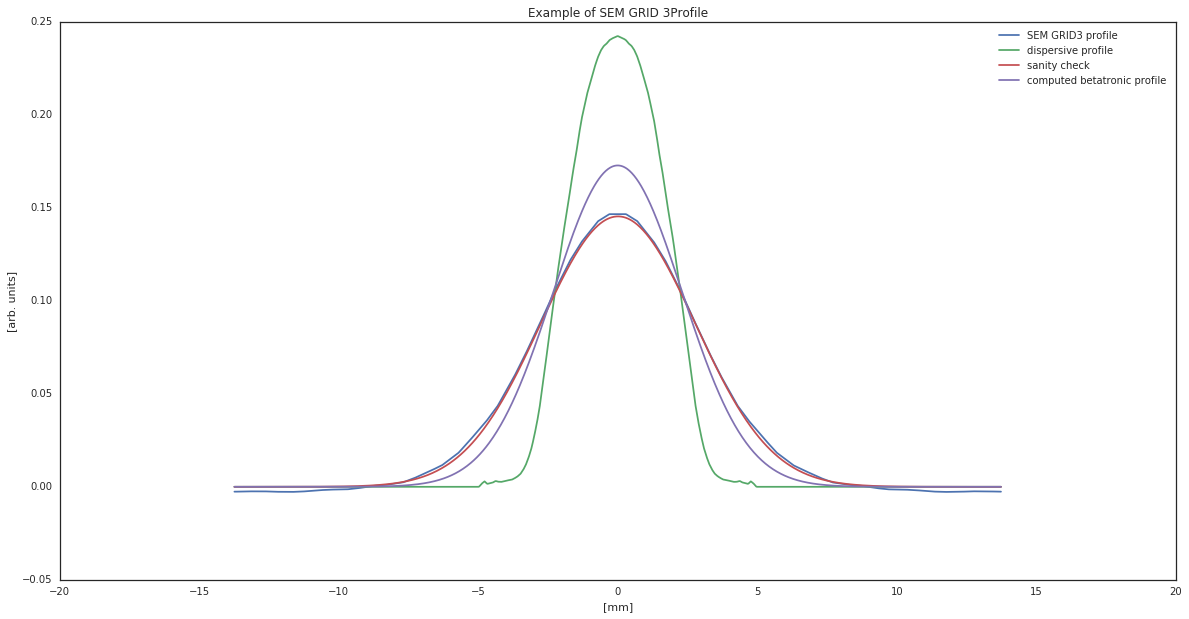

In [18]:
#from Guido's toolbox and re-adapted for a simple Gaussian Fit
def computeTransverseEmittance(position_mm,
                               profile_arb_unit,
                               off_momentum_distribution_arb_unit,
                               deltaP_P,
                               betaGammaRelativistic,
                               betaOptical_m,
                               Dispersion_m):
    x_inj=position_mm;
    y_inj=profile_arb_unit;
  
    # original    
    # popt,pcov = gpToolbox.makeGaussianFit_5_parameters(x_inj,y_inj)
    # y_inj_1=gpToolbox.Gaussian_5_parameters(x_inj,popt[0],popt[1],popt[2],popt[3],popt[4])
    # y_inj_2=y_inj-popt[0]-popt[1]*x_inj
    # x_inj_2=x_inj-popt[3]
     
    popt,pcov = gpToolbox.makeGaussianFit(x_inj,y_inj)
    y_inj_1=gpToolbox.Gaussian_5_parameters(x_inj,0,0,popt[0],popt[1],popt[2])
    y_inj_2=y_inj
    x_inj_2=x_inj-popt[1]
    
    # define a reasonable range for the interpolation
    #i = np.where(y_inj>=0)
    #X = x_inj[i].astype(float)
    #limit = math.fabs(X[-1]-X[0])/2
    #print X, (X[-1]-X[0])/2
    # define a reasonable range for the interpolation
    limit = 5 * popt[2]
    x_inj_3=np.linspace(-limit,limit,1000)

    # uncomment for hardcoded range
    #x_inj_3=np.linspace(-9,9,1000)
    
    y_inj_3=scipy.interpolate.interp1d(x_inj_2,y_inj_2)(x_inj_3)
    y_inj_4=y_inj_3/np.trapz(y_inj_3,x_inj_3)
    y_inj_5=(y_inj_4+y_inj_4[::-1])/2

    profile_step1_5GaussianFit=y_inj_1
    profile_step2_dropping_baseline=y_inj_2
    profile_step3_interpolation=y_inj_3
    profile_step4_normalization=y_inj_4
    profile_step5_symmetric=y_inj_5
    position_step1_centering_mm=x_inj_2;
    position_step2_interpolation_mm=x_inj_3;
    Dispersion_mm=Dispersion_m*1000

    Dispersive_position_step1_mm=deltaP_P*Dispersion_mm
    Dispersive_profile_step1_normalized=off_momentum_distribution_arb_unit/np.trapz(off_momentum_distribution_arb_unit,Dispersive_position_step1_mm)
    Dispersive_position_step2_mm=position_step2_interpolation_mm
    Dispersive_step2_interpolation=scipy.interpolate.interp1d(Dispersive_position_step1_mm,Dispersive_profile_step1_normalized,bounds_error=0,fill_value=0)(Dispersive_position_step2_mm)
    Dispersive_step3_symmetric=(Dispersive_step2_interpolation+Dispersive_step2_interpolation[::-1])/2

    def myConvolution(position_step2_interpolation_mm,sigma):
        myConv=np.convolve(Dispersive_step3_symmetric, myToolbox.gaussian(position_step2_interpolation_mm,0,sigma), 'same')
        myConv/=np.trapz(myConv,position_step2_interpolation_mm)
        return myConv

    def myError(sigma):
        myConv=np.convolve(Dispersive_step3_symmetric, myToolbox.gaussian(position_step2_interpolation_mm,0,sigma), 'same')
        myConv/=np.trapz(myConv,position_step2_interpolation_mm)
        aux=myConv-profile_step5_symmetric
        return np.std(aux), aux, myConv

    popt,pcov = curve_fit(myConvolution,position_step2_interpolation_mm,profile_step5_symmetric,p0=[1])
    sigma=popt;
    emittance=sigma**2/betaOptical_m*betaGammaRelativistic
    return {'emittance_um':emittance,'sigma_mm':sigma,'position_mm':position_step2_interpolation_mm, 'profile': profile_step5_symmetric, 'Dispersive_position_mm':Dispersive_position_step2_mm, 'Dispersive_profile':Dispersive_step3_symmetric,
           'convolutionBackComputed':myConvolution(position_step2_interpolation_mm,sigma),
           'betatronicProfile':myToolbox.gaussian(position_step2_interpolation_mm,0,sigma)
           }

# test to display the result
i=10
grid_n = '3'

# finally the beta optics is not needed as it used to extract the emittance, but we will
# use the functions only and the 3 SEM grid method
modelBetaOptics_m = 10.0 #m
measuDispersion_m = math.fabs(dispersion_measured['r'+ring][plane]['SG'+grid_n])

out=computeTransverseEmittance(myDataFrame.iloc[i]['BTM_BSFHV0'+grid_n+'.Acquisition.value.projPositionSet1'],
                               myDataFrame.iloc[i]['BTM_BSFHV0'+grid_n+'.Acquisition.value.projDataSet1'],
                               myDataFrame.iloc[i]['momentumProfile']['myProfile'],
                               myDataFrame.iloc[i]['momentumProfile']['deltaP_P'],
                               myDataFrame.iloc[i]['momentumProfile']['beta']*myDataFrame.iloc[i]['momentumProfile']['gamma'],
                               betaOptical_m=modelBetaOptics_m,Dispersion_m=measuDispersion_m)

plt.figure(figsize=(20,10))
plt.plot(out['position_mm'],out['profile'],label='SEM GRID' + grid_n + ' profile')
plt.hold('on')
plt.plot(out['Dispersive_position_mm'],out['Dispersive_profile'],label='dispersive profile')
plt.hold('off')
plt.xlabel('[mm]')
plt.ylabel('[arb. units]')
plt.plot(out['position_mm'],out['convolutionBackComputed'],label='sanity check')
plt.plot(out['position_mm'],out['betatronicProfile'],label='computed betatronic profile')
plt.legend()
plt.xlim([-20,20])
print(out['sigma_mm'] )
#str(myDataFrame.iloc[i]['momentumProfile']['gamma']) +' '+ str(myDataFrame.iloc[i]['momentumProfile']['ctime']))
plt.title('Example of SEM GRID ' + grid_n +'Profile')

#X = myDataFrame.iloc[i]['BTM_BSFHV0'+grid_n+'.Acquisition.value.projPositionSet1']
#print X, X[1],X[-2]


[[  1.        -0.         0.      ]
 [  1.        -4.97       6.175225]
 [  1.        -9.944     24.720784]]

bet. sigma at 1st SEM =  1.98196657027  mm
bet. sigma at 2nd SEM =  1.41221262483  mm
bet. sigma at 3rd SEM =  2.33116319701  mm
RMS emittance =  0.918780644897  mm mrad
Normalized emittance =  2.09769565378 mm mrad
beta (twiss) =  4.27543996218 m
alpha (twiss) =  1.01137802072
[[  1.        -0.         0.      ]
 [  1.        -4.97       6.175225]
 [  1.        -9.944     24.720784]]

disp. at 1st SEM =  1.5515  mm
disp. at 2nd SEM =  0.052911  mm
disp. at 3rd SEM =  1.429  mm

bet. sigma at 1st SEM =  [ 1.99214077]  mm
bet. sigma at 2nd SEM =  [ 1.43601434]  mm
bet. sigma at 3rd SEM =  [ 2.30909812]  mm
RMS emittance =  0.919134914708  mm mrad
Normalized emittance =  2.09850449782 mm mrad
beta (twiss) =  [ 4.31778271] m
alpha (twiss) =  [ 0.983401]


2.098504497817595

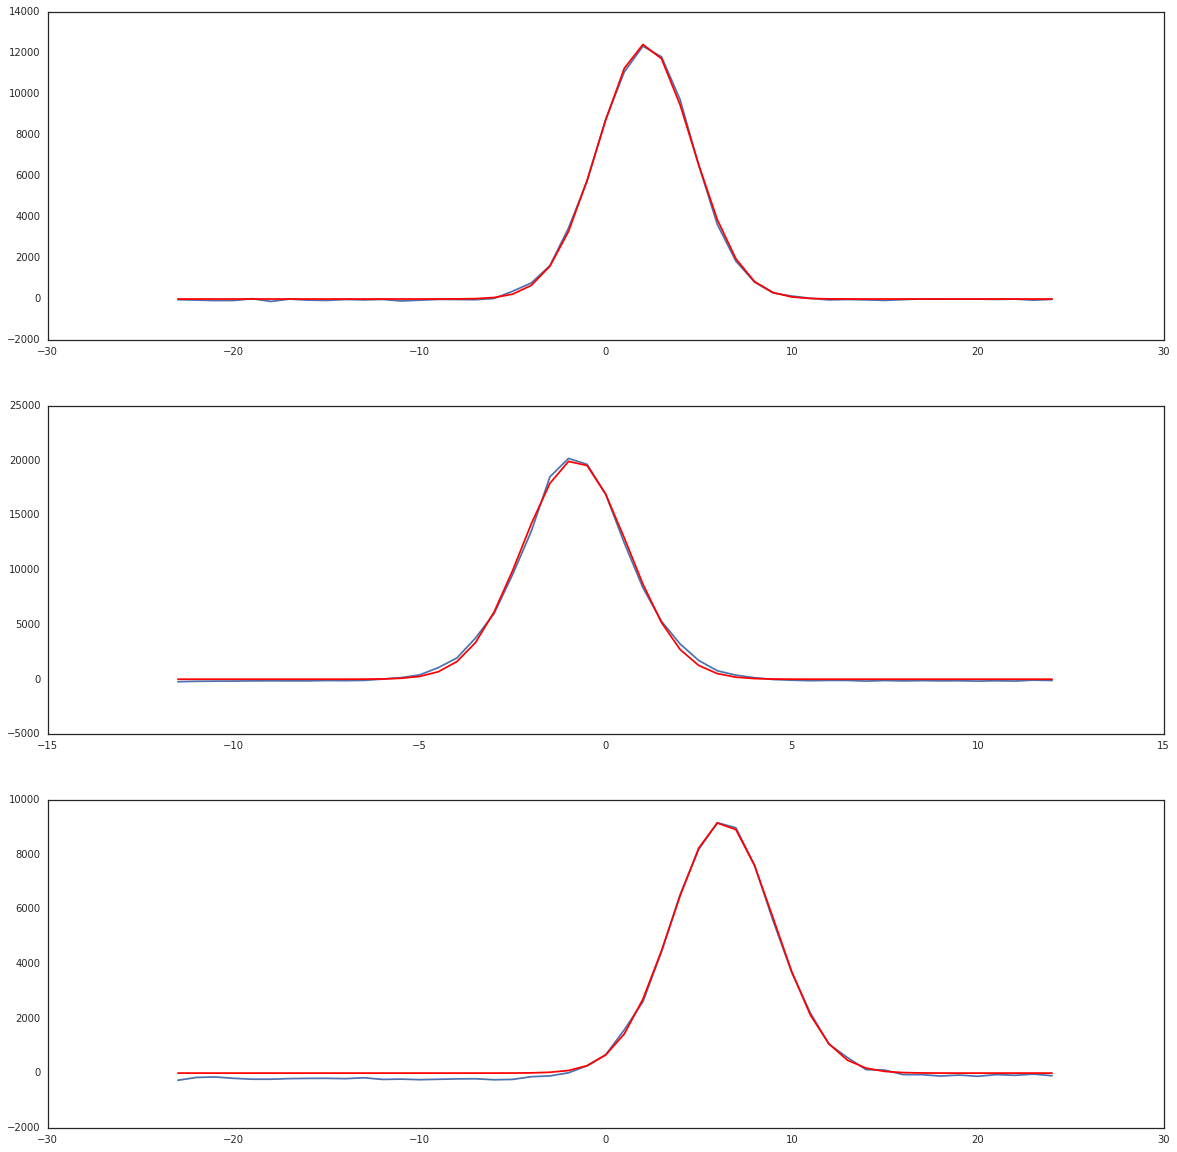

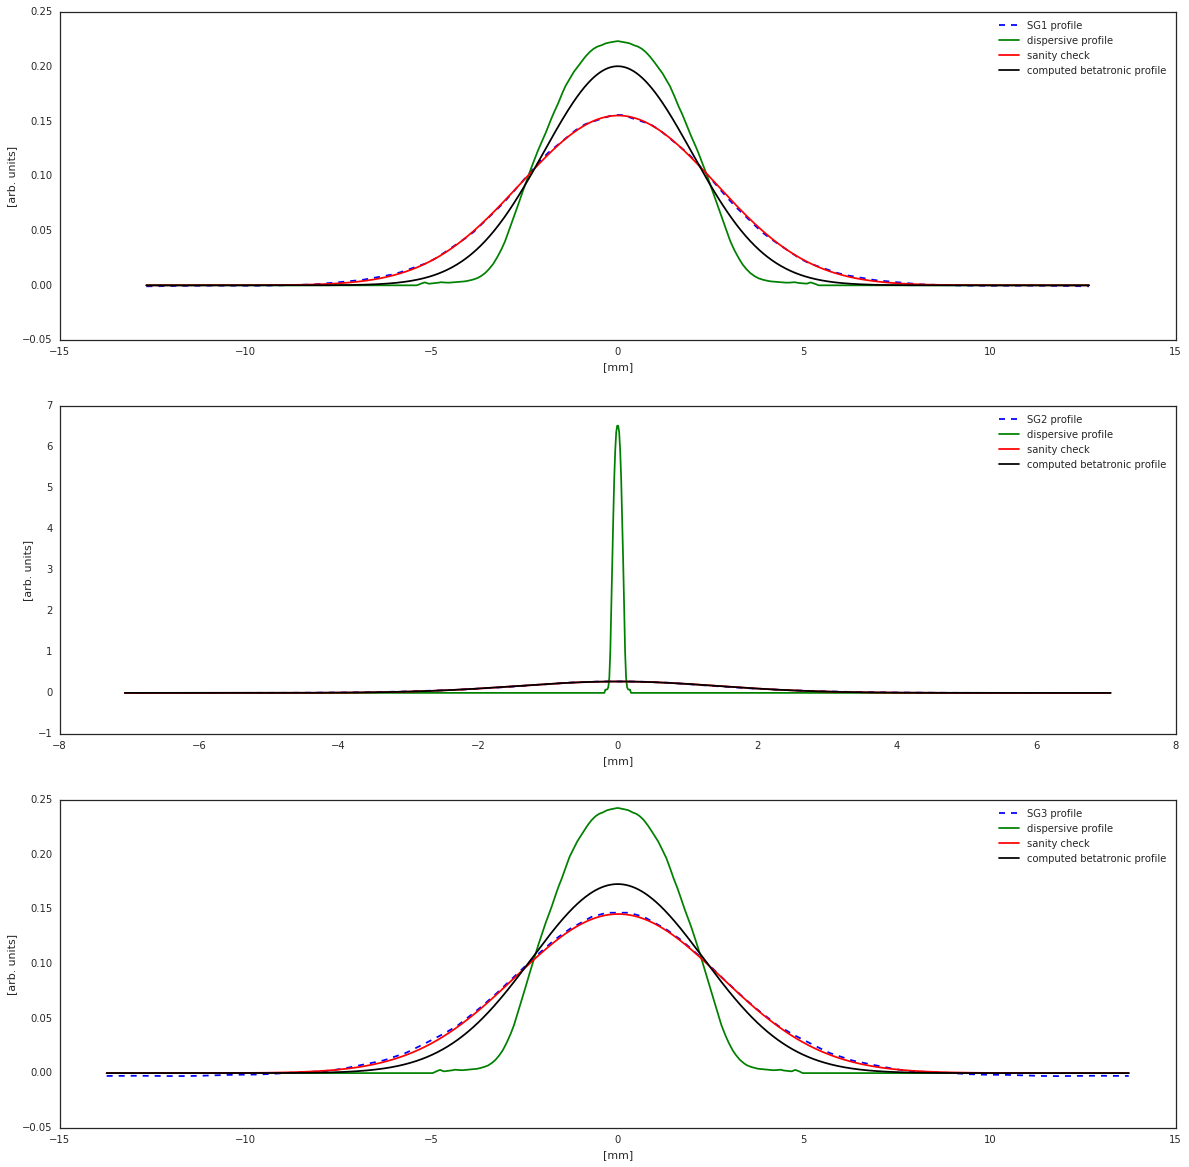

In [19]:
# here I defined the method. I should include the fit and then remove the dispersion at that point
isVerbose=False

def fullPower(myDataFrame):
     
    # Dispersion
    D_1 = math.fabs( dispersion_measured['r'+ring][plane]['SG1'] )
    D_2 = math.fabs( dispersion_measured['r'+ring][plane]['SG2'] )
    D_3 = math.fabs( dispersion_measured['r'+ring][plane]['SG3'] )
    
    # this is irrelevant for our calculation. Put it to a reasonable number though
    modelBetaOptics_m = 10.0 #m
    
    # apply the full deconvolution
    out1=computeTransverseEmittance(myDataFrame['BTM_BSFHV01.Acquisition.value.projPositionSet1'],
                                    myDataFrame['BTM_BSFHV01.Acquisition.value.projDataSet1'],
                                    myDataFrame['momentumProfile']['myProfile'],
                                    myDataFrame['momentumProfile']['deltaP_P'],
                                    beta_rel * gamma_rel,                                    
                                    betaOptical_m=modelBetaOptics_m,Dispersion_m=D_1)

    out2=computeTransverseEmittance(myDataFrame['BTM_BSFHV02.Acquisition.value.projPositionSet1'],
                                    myDataFrame['BTM_BSFHV02.Acquisition.value.projDataSet1'],
                                    myDataFrame['momentumProfile']['myProfile'],
                                    myDataFrame['momentumProfile']['deltaP_P'],
                                    beta_rel * gamma_rel,                                    
                                    betaOptical_m=modelBetaOptics_m,Dispersion_m=D_2)

    out3=computeTransverseEmittance(myDataFrame['BTM_BSFHV03.Acquisition.value.projPositionSet1'],
                                    myDataFrame['BTM_BSFHV03.Acquisition.value.projDataSet1'],
                                    myDataFrame['momentumProfile']['myProfile'],
                                    myDataFrame['momentumProfile']['deltaP_P'],
                                    beta_rel * gamma_rel,                                    
                                    betaOptical_m=modelBetaOptics_m,Dispersion_m=D_3)

    # only betatronic contribution, i.e. removing dispersion contribution
    # keep in mind that the dispersion is given in m while the sigma is in mm... convertion factor!
    sigma_bet_1 = out1['sigma_mm']
    sigma_bet_2 = out2['sigma_mm']
    sigma_bet_3 = out3['sigma_mm']

    # the input vector
    x = [sigma_bet_1**2, sigma_bet_2**2, sigma_bet_3**2]

    
    ##
    # construct the transport matrix when only drift between grids!
    # See slide 21 of https://cas.web.cern.ch/cas/France-2008/Lectures/Braun-Emittance.pdf
    Row_1 = [1, -2*La, La**2];
    Row_2 = [1, -2*Lb, Lb**2];
    Row_3 = [1, -2*Lc, Lc**2];

    # Create the matrix M
    M = np.matrix( [Row_1,Row_2,Row_3]) 
    if isVerbose:
        print M

    # left for reference
    # inverse of M
    # print M.I
    #print linalg.solve(A, x)     # Solve the linear equation system.
    
    ## output vector
    out = np.linalg.solve(M, x)

    # twiss parameters
    beta_x_emitRMS  = out[0]
    alpha_x_emitRMS = out[1]
    gamma_x_emitRMS = out[2]

    # RMS Emittance
    emitRMS = math.sqrt( beta_x_emitRMS*gamma_x_emitRMS - alpha_x_emitRMS**2)

    # Normalized Emittance
    emittance = emitRMS * beta_rel * gamma_rel

    # twiss parameter
    betaTwiss  = beta_x_emitRMS / emitRMS
    alphaTwiss = alpha_x_emitRMS/ emitRMS

    #============================================================================
    if not isVerbose:
       return emittance#,betaTwiss,alphaTwiss

    print '\ndisp. at 1st SEM = ', D_1, ' mm'
    print   'disp. at 2nd SEM = ', D_2, ' mm'
    print   'disp. at 3rd SEM = ', D_3, ' mm'

    print '\nbet. sigma at 1st SEM = ', sigma_bet_1, ' mm'
    print   'bet. sigma at 2nd SEM = ', sigma_bet_2, ' mm'
    print   'bet. sigma at 3rd SEM = ', sigma_bet_3, ' mm'

    # print the output of the test
    print "RMS emittance = ", emitRMS, " mm mrad"
    print "Normalized emittance = ", emittance, "mm mrad"
    print "beta (twiss) = ", betaTwiss, "m"
    print "alpha (twiss) = ", alphaTwiss

    fig = plt.figure(figsize=(20,20))
    ax1 = fig.add_subplot(311)
    ax1.plot(out1['position_mm'],out1['profile'],'b--',label='SG1 profile')
    ax1.set_xlabel('[mm]')
    ax1.set_ylabel('[arb. units]')
 
    ax1.hold('on')
    ax1.plot(out1['Dispersive_position_mm'],out1['Dispersive_profile'],'g',label='dispersive profile')
    ax1.plot(out1['position_mm'],out1['convolutionBackComputed'],'r',label='sanity check')
    ax1.plot(out1['position_mm'],out1['betatronicProfile'],'k',label='computed betatronic profile')
    ax1.legend()
    ax1.hold('off')


    ax2 = fig.add_subplot(312)
    ax2.plot(out2['position_mm'],out2['profile'],'b--',label='SG2 profile')
    ax2.set_xlabel('[mm]')
    ax2.set_ylabel('[arb. units]')
 
    ax2.hold('on')
    ax2.plot(out2['Dispersive_position_mm'],out2['Dispersive_profile'],'g',label='dispersive profile')
    ax2.plot(out2['position_mm'],out2['convolutionBackComputed'],'r',label='sanity check')
    ax2.plot(out2['position_mm'],out2['betatronicProfile'],'k',label='computed betatronic profile')
    ax2.legend()
    ax2.hold('off')


    ax3 = fig.add_subplot(313)
    ax3.plot(out3['position_mm'],out3['profile'],'b--',label='SG3 profile')
    ax3.set_xlabel('[mm]')
    ax3.set_ylabel('[arb. units]')
 
    ax3.hold('on')
    ax3.plot(out3['Dispersive_position_mm'],out3['Dispersive_profile'],'g',label='dispersive profile')
    ax3.plot(out3['position_mm'],out3['convolutionBackComputed'],'r',label='sanity check')
    ax3.plot(out3['position_mm'],out3['betatronicProfile'],'k',label='computed betatronic profile')
    ax3.legend()
    ax3.hold('off')
    
    return emittance#,betaTwiss,alphaTwiss


# add the new emittance calculation with full Dispersion deconvolution to the dataframe
myDataFrame['emittanceSGFull'] = myDataFrame.apply( fullPower , axis=1)

# test for plotting
i=10
isVerbose = True
simpleMethod ( myDataFrame.iloc[i] )
#simpleMethodFit5Pars ( myDataFrame.iloc[i] )
fullPower ( myDataFrame.iloc[i] )


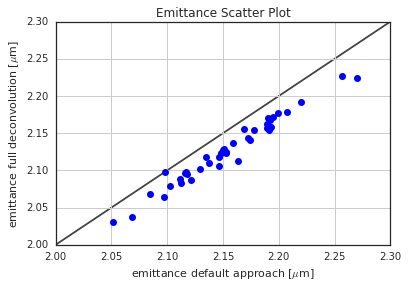

In [20]:
# plot of emittance from my method vs JF's
#plt.plot(myDataFrame['BTM_BSFHV01.Emittance.value.emittance'],myDataFrame['emittanceSGFull'],'bo')

f = plt.figure()

plt.plot(myDataFrame['emittanceSG'],myDataFrame['emittanceSGFull'],'bo')
plt.xlabel('emittance default approach [$\mu$m]')
plt.ylabel('emittance full deconvolution [$\mu$m]')
plt.grid(True)
plt.title('Emittance Scatter Plot')

plt.hold('on')
lims = [
    np.min([plt.xlim(), plt.ylim()]),  # min of both axes
    np.max([plt.xlim(), plt.ylim()]),  # max of both axes
]

# now plot both limits against eachother
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.xlim(lims)
plt.ylim(lims)
plt.hold('off')

f.savefig('plots/scatterEmittanceFullvsDef_semgrid_r'+ring+'_p'+plane+'_gp.pdf')
f.savefig('plots/scatterEmittanceFullvsDef_semgrid_r'+ring+'_p'+plane+'_gp.png')


Avg Emittance Full =  2.12730388309 +/- 0.0441905885582 mm mrad
Avg Emittance Deft =  2.15399432454 +/- 0.0465481335663 mm mrad
Avg Emittance Diff =  -0.026690441449 +/- 0.00862073459386 mm mrad


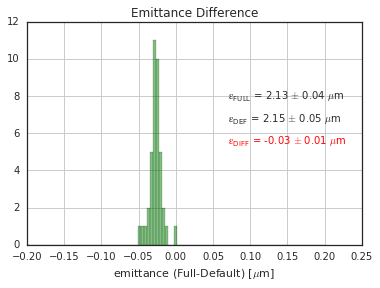

In [21]:
bins = np.linspace(-0.2, 0.2, 100)

fullEmittance   = myDataFrame['emittanceSGFull'].values
#jfEmittance   = myDataFrame['BTM_BSFHV01.Emittance.value.emittance'].values
deftEmittance   = myDataFrame['emittanceSG'].values
diffEmittance = fullEmittance-deftEmittance

f = plt.figure()

plt.hist( diffEmittance, bins, facecolor='green', alpha=0.5) 
plt.xlabel('emittance (Full-Default) [$\mu$m]')
plt.title('Emittance Difference')
plt.grid(True)

full_avg = np.mean(fullEmittance)
full_std = np.std (fullEmittance)

deft_avg = np.mean(deftEmittance)
deft_std = np.std (deftEmittance)

diff_avg = np.mean(diffEmittance)
diff_std = np.std (diffEmittance)

plt.annotate('$\mathregular{\epsilon_{FULL}}$' + 
             ' = {0:0.2f} $\pm$ {1:0.2f} $\mu$m'.format(full_avg,full_std), 
            (0.60, 0.65), textcoords='axes fraction', xycoords='axes fraction', size=10)
plt.annotate('$\mathregular{\epsilon_{DEF}}$' + 
             ' = {0:0.2f} $\pm$ {1:0.2f} $\mu$m'.format(deft_avg,deft_std), 
            (0.60, 0.55), textcoords='axes fraction', xycoords='axes fraction', size=10)
plt.annotate('$\mathregular{\epsilon_{DIFF}}$' + 
             ' = {0:0.2f} $\pm$ {1:0.2f} $\mu$m'.format(diff_avg,diff_std), 
            (0.60, 0.45), textcoords='axes fraction', xycoords='axes fraction', size=10, color='red')

f.savefig('plots/histoEmittanceFULLmenDEF_semgrid_r'+ring+'_p'+plane+'_gp.pdf')
f.savefig('plots/histoEmittanceFULLmenDEF_semgrid_r'+ring+'_p'+plane+'_gp.png')

print "Avg Emittance Full = ", full_avg, "+/-", full_std , "mm mrad"
print "Avg Emittance Deft = ", deft_avg, "+/-", deft_std,  "mm mrad"
print "Avg Emittance Diff = ", diff_avg, "+/-", diff_std,  "mm mrad"

In [22]:
if saveData:
    myDataFrame.to_pickle('pickles/dataframe_sem_grid_r' + ring + "_p" + plane)

In [23]:
# X = myDataFrame.iloc[0]['BTM_BSFHV03.Acquisition.value.projPositionSet1']
# Y = myDataFrame.iloc[0]['BTM_BSFHV03.Acquisition.value.projDataSet1']
# #print X,Y
# i = np.where(Y>0)
# X=np.array(X[i]).astype(float)
# Y=Y[i].astype(float)
# print X
# print Y

# mean = sum(X * Y) / sum(Y)
# print mean

# print Y
# print (X-mean)**2
# #test  = sum(Y * ((X - mean)**2))
# print float(sum(Y * (X - mean)**2) )

# #long(sigma2)
# #sigma2 = np.sqrt(sum(Y*(X - mean)**2) / sum(Y))

# #popt,pcov = curve_fit(gpToolbox.Gaussian, X, Y, p0=[max(Y), mean, sigma])


In [24]:
# Example of computing the emittance back
# Numbers taken from https://ab-dep-op-elogbook.web.cern.ch/ab-dep-op-elogbook/elogbook/secure/view.php?attachId=1656042

# Default method, removing the dispersion contribution assuming it is a Gaussian distribution
# Example R4V

# Dp_p = 0.950

# D_1 = dispersion_measured['r4']['V']['SG1']
# D_2 = dispersion_measured['r4']['V']['SG2']
# D_3 = dispersion_measured['r4']['V']['SG3']


# # measured beam sizes at the grids, including dispersion
# s_1 = 1.641 # mm
# s_2 = 0.800 # mm
# s_3 = 1.504 # mm

# # only betatronic contribution, i.e. removing dispersion contribution
# sigma_bet_1 = math.sqrt( s_1**2 - (D_1*Dp_p)**2 )
# sigma_bet_2 = math.sqrt( s_2**2 - (D_2*Dp_p)**2 )
# sigma_bet_3 = math.sqrt( s_3**2 - (D_3*Dp_p)**2 )

# x = [sigma_bet_1**2, sigma_bet_2**2, sigma_bet_3**2]

# out =  linalg.solve(M, x)

# beta_x_emitRMS  = out[0]
# alpha_x_emitRMS = out[1]
# gamma_x_emitRMS = out[2]

# # RMS Emittance
# emitRMS = math.sqrt( beta_x_emitRMS*gamma_x_emitRMS - alpha_x_emitRMS**2)

# # Normalized Emittance
# emittance = emitRMS * beta_rel *gamma_rel

# # twiss parameter
# betaTwiss  = beta_x_emitRMS / emitRMS
# alphaTwiss = alpha_x_emitRMS/ emitRMS

# # print the output of the test
# print "RMS emittance = ", emitRMS, " mm mrad"
# print "Normalized emittance = ", emittance, "mm mrad"
# print "beta (twiss) = ", betaTwiss, "m"
# print "alpha (twiss) = ", alphaTwiss

In [25]:
print 'Done!'

Done!
